### 加了visualisation（取样数200）
#### 问题：词语carte会报错，比如：IndexError: index 143 is out of bounds for axis 0 with size 143

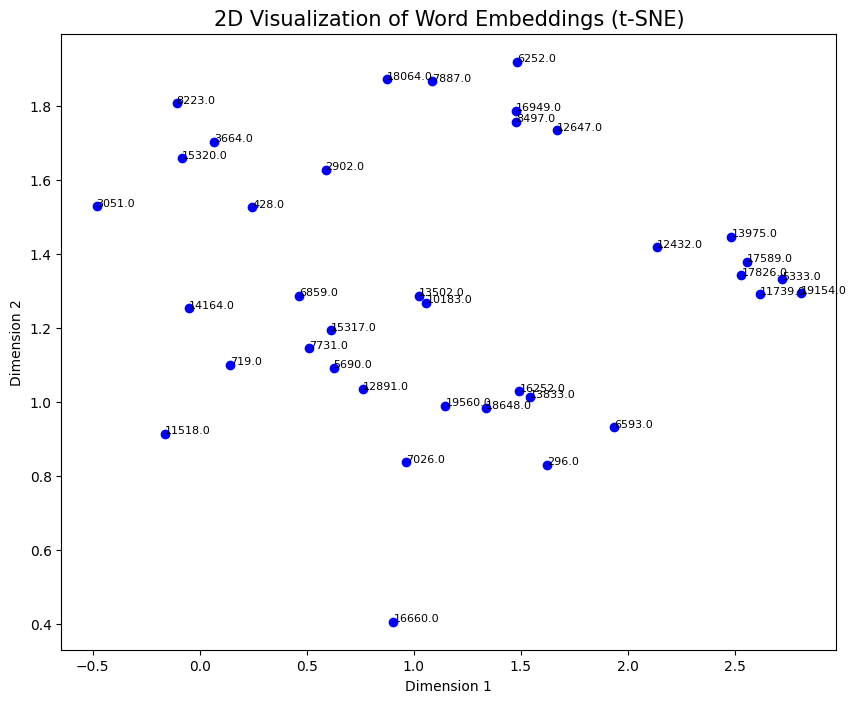

Word: bureau
Occurrences: 37
Polysemy score: 0.1470

Review ID 11518.0: [-0.03748124  0.21968728 -0.01089785 -0.05956695 -0.178989  ]...
Review ID 7887.0: [-0.04420759  0.22180554  0.10345478 -0.13295151  0.017223  ]...
Review ID 3051.0: [-0.0400084   0.1510016   0.12496528 -0.14272505 -0.09849904]...
Review ID 16660.0: [ 0.11483775  0.20865445 -0.05989716 -0.10096084 -0.1148338 ]...
Review ID 19154.0: [ 0.10800091  0.13973536 -0.25760716  0.09992494  0.04349409]...
Review ID 14164.0: [-0.12989035  0.02457075 -0.18170887  0.00932871 -0.03976591]...
Review ID 5333.0: [ 0.04138172  0.16440828 -0.24794783  0.17720883 -0.01201916]...
Review ID 15317.0: [-0.04502966 -0.1578922  -0.11980693  0.02034242 -0.07357767]...
Review ID 13975.0: [ 0.07566959  0.02566606 -0.03196475  0.15129757 -0.01445493]...
Review ID 10183.0: [-0.03328045 -0.05295298 -0.1073062   0.02649246 -0.05967229]...
Review ID 6252.0: [ 0.02856776  0.22426093  0.0614058   0.00929368 -0.0387228 ]...
Review ID 8497.0: [ 0.02656

In [16]:
import pandas as pd
import torch
from transformers import CamembertTokenizer, CamembertModel
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 加载法语模型
nlp = spacy.load("fr_core_news_sm")

def lemmatize_text(text):
    """使用spaCy进行词形还原"""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def preprocess_and_embed(texts, ids, word, tokenizer, model, batch_size=8):
    """预处理文本并获取目标词嵌入"""
    word_embeddings = []
    review_embeddings = []  # 存储每个review的embedding信息

    # 对批次进行编码
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_ids = ids[i:i + batch_size]  # 对应的id
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

        # 获取每个句子中目标词的位置
        word_ids = [next((i+1 for i, token in enumerate(tokenizer.tokenize(text)) if word in token), None) for text in batch_texts]

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state

            # 提取目标词的embeddings并记录索引
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    word_embeddings.append(hidden_states[idx, word_id].numpy())
                    review_embeddings.append({'id': batch_ids[idx], 'embedding': hidden_states[idx, word_id].numpy()})

    return word_embeddings, review_embeddings

def visualize_embeddings(word_embeddings, review_ids):
    """使用t-SNE可视化目标词的二维嵌入"""
    word_embeddings_array = np.array(word_embeddings)

    # 检查样本数量，并调整perplexity
    n_samples = len(word_embeddings_array)
    perplexity_value = min(30, n_samples - 1)  # 将perplexity设为样本数-1，最大为30

    # 使用t-SNE降维
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced_embeddings = tsne.fit_transform(word_embeddings_array)

    # 绘制二维散点图
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')

    # 显示id标签
    for i, review_id in enumerate(review_ids):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(review_id), fontsize=8)

    plt.title("2D Visualization of Word Embeddings (t-SNE)", fontsize=15)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


def analyze_word(word, df, sample_size=100):
    """分析单个词的多义性"""
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base')
    model.eval()

    relevant_texts = df[df['review'].str.contains(word, case=False, na=False, regex=False)]
    if relevant_texts.empty:
        print(f"No occurrences found for word: {word}")
        return None

    relevant_texts = relevant_texts.sample(n=min(len(relevant_texts), sample_size), random_state=42)

    # 获取对应的id和预处理文本
    ids = relevant_texts.iloc[:, 0].values  # 第一列是id
    processed_texts = [lemmatize_text(re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()) for text in relevant_texts['review']]

    word_embeddings, review_embeddings = preprocess_and_embed(processed_texts, ids, word, tokenizer, model)

    if len(word_embeddings) < 2:
        return None

    # 计算余弦相似度矩阵并得到多义性分数
    embeddings_array = np.array(word_embeddings)
    norm = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
    similarity_matrix = np.dot(embeddings_array / norm, (embeddings_array / norm).T)

    polysemy_score = np.std(similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)])

    # 可视化
    visualize_embeddings(word_embeddings, ids)

    return {
        'word': word,
        'occurrences': len(word_embeddings),
        'polysemy_score': polysemy_score,
        'review_embeddings': review_embeddings  # 返回每个review的目标词嵌入和对应的id
    }

def quick_polysemy_analysis(file_path, target_words, sample_size=100):
    """主分析函数"""
    df = pd.read_csv(file_path, header=None, names=['id', 'film-url', 'review', 'polarity'])

    results = []
    for word in target_words:
        analysis_result = analyze_word(word, df, sample_size)
        if analysis_result:  # 确保返回值不是 None
            results.append(analysis_result)

    for result in results:
        print(f"Word: {result['word']}")
        print(f"Occurrences: {result['occurrences']}")
        print(f"Polysemy score: {result['polysemy_score']:.4f}\n")

        # 输出每个review的目标词嵌入及其对应的id
        for review in result['review_embeddings']:
            print(f"Review ID {review['id']}: {review['embedding'][:5]}...")  # 显示嵌入的前5个数值，避免输出过长

    return results


# 使用示例
file_path = 'test.csv'
target_words = ['bureau']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)
